# PLV Model Prototype 3

In [140]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install requests pandas
# !pip install statsmodels

import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from statsmodels.tsa.stattools import adfuller

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import xgboost as xgb

## Fetch Data from Subgraph API

Send the GraphQL query to the subgraph API endpoint and fetch the response.

In [141]:
def date_to_unix(date_str):
    """Convert a date string in 'YYYY-MM-DD' format to a Unix timestamp."""
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt.timestamp())

def make_price_query(pool_address, start_ts, end_ts):
    """Create a GraphQL query string for fetching price, volume, and liquidity of a Uniswap V3 pool."""
    return f"""
    {{
      poolHourDatas(first: 1000, where: {{pool: \"{pool_address}\", periodStartUnix_gte: {start_ts}, periodStartUnix_lte: {end_ts}}}, orderBy: periodStartUnix, orderDirection: asc) {{
        periodStartUnix
        token0Price
        volumeUSD
        liquidity
      }}
    }}
    """

def fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date):
    """
    Fetch hourly price (token0Price as 'price'), volumeUSD, liquidity, and datetimes for a Uniswap V3 pool from the subgraph.
    Dates should be in 'YYYY-MM-DD' format.
    Returns a pandas DataFrame with columns: periodStartUnix, price, volumeUSD, liquidity
    """
    start_ts = date_to_unix(start_date)
    end_ts = date_to_unix(end_date)
    all_data = []
    last_ts = start_ts
    while True:
        graphql_query = make_price_query(pool_address, last_ts, end_ts)
        payload = {
            "query": graphql_query,
            "operationName": "Subgraphs",
            "variables": {}
        }
        url = f"https://gateway.thegraph.com/api/subgraphs/id/{subgraph_id}"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Query failed with status code {response.status_code}: {response.text}")
        result = response.json()
        hour_data = result['data']['poolHourDatas']
        if not hour_data:
            break
        all_data.extend(hour_data)
        if len(hour_data) < 1000:
            break
        # Update last_ts to one after the last returned timestamp to avoid overlap
        last_ts = int(hour_data[-1]['periodStartUnix']) + 1

    df = pd.DataFrame(all_data)
    if not df.empty:
        df['periodStartUnix'] = pd.to_datetime(df['periodStartUnix'], unit='s')
        df = df.rename(columns={"token0Price": "price"})
        df['price'] = pd.to_numeric(df['price'])
        df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])
        df['liquidity'] = pd.to_numeric(df['liquidity'], errors='coerce', downcast=None).astype(float)
    return df

In [ ]:
# Define training and test pool addresses
api_key = "d1762c97d76a973e078c5536742bd237"  # Replace with your API key
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"    # Replace with your subgraph id

start_date = "2024-06-01"
end_date = "2025-06-01"
train_end_date = "2025-04-01"  

# Pool address to test on (should be in the same format)
main_pool_address = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"  # Example test pool

# Pools to pretrain on
pre_train_pool_addresses = [
    "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640", # USDC/ETH
    "0x99ac8cA7087fA4A2A1FB6357269965A2014ABc35", # WBTC/USDC
    "0xe8f7c89C5eFa061e340f2d2F206EC78FD8f7e124", # WBTC/cbBTC
    "0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168", # DAI/USDC
    "0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36", # ETH/USDT
    "0x3416cF6C708Da44DB2624D63ea0AAef7113527C6", # USDC/USDT
    "0xC5c134A1f112efA96003f8559Dba6fAC0BA77692", # WHITE/ETH
    "0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8", # USDC/ETH
    "0x9Db9e0e53058C89e5B94e29621a205198648425B", # WBTC/USDT
    "0x87428a53e14d24Ab19c6Ca4939B4df93B8996cA9"
]
pre_train_pool_addresses = [addr.lower() for addr in pre_train_pool_addresses]  # Ensure all addresses are in lowercase

# --- Fetch and cache all pool data at the start ---
pool_addresses = [main_pool_address] + pre_train_pool_addresses

# Fetch and store all pool data in a dictionary
pool_data_dict = {}
print(f"Fetching data for main pool: {main_pool_address}")
df = fetch_pool_hourly_data(api_key, subgraph_id, main_pool_address, start_date, end_date)
print(f"Data for main pool fetched, shape: {df.shape}")
pool_data_dict[main_pool_address] = df
for pool_addr in pre_train_pool_addresses:
    print(f"Fetching data for pool: {pool_addr}")
    df_pool = fetch_pool_hourly_data(api_key, subgraph_id, pool_addr, start_date, train_end_date)
    print(f"Data for pool {pool_addr} fetched, shape: {df_pool.shape}")
    pool_data_dict[pool_addr] = df_pool


Fetching data for main pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed
Data for main pool fetched, shape: (8125, 4)
Fetching data for pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
Data for main pool fetched, shape: (8125, 4)
Fetching data for pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640


## Feature Engineering: Price Returns, Volatility, Moving Averages, and Time Features

In this section, we compute engineered features for the PLV model, including:
- Price returns (log and simple)
- Rolling volatility (e.g., 6-hour standard deviation)
- Moving averages (e.g., 6-hour, 24-hour)
- Time-based features (hour of day, day of week, month, season)

These features are useful for modeling and backtesting strategies on Uniswap V3 pool data.

In [ ]:
# Feature engineering function (reuse from earlier)
def feature_engineering(df):
    df = df.copy()

    if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(df['periodStartUnix'], unit='s')
    df = df.sort_values('datetime').reset_index(drop=True)

    # Returns
    df['price_return'] = df['price'].pct_change()
    df['liquidity_return'] = df['liquidity'].pct_change()
    df['volume_return'] = df['volumeUSD'].pct_change()

    # Outlier removal
    def remove_outliers_iqr(series, k=3.0):
        q_01 = series.quantile(0.3)
        q_90 = series.quantile(0.6)
        iqr = q_90 - q_01
        lower = q_01 - k * iqr
        upper = q_90 + k * iqr
        return series.where((series >= lower) & (series <= upper))

    for col in ['price_return', 'liquidity_return', 'volume_return']:
        if col in df.columns:
            df[col] = remove_outliers_iqr(df[col])
            df[col] = df[col].interpolate(method='linear', limit_direction='both')

    # Price-based volatility and moving averages
    df['price_volatility_3h'] = df['price_return'].rolling(window=3).std()
    df['price_volatility_6h'] = df['price_return'].rolling(window=6).std()
    df['price_volatility_24h'] = df['price_return'].rolling(window=24).std()
    df['price_ma_3h'] = df['price_return'].rolling(window=3).mean()
    df['price_ma_6h'] = df['price_return'].rolling(window=6).mean()
    df['price_ma_24h'] = df['price_return'].rolling(window=24).mean()

    # Liquidity-based volatility and moving averages (shifted by 1 to avoid lookahead bias)
    df['liquidity_volatility_3h'] = df['liquidity_return'].shift(1).rolling(window=3).std()
    df['liquidity_volatility_6h'] = df['liquidity_return'].shift(1).rolling(window=6).std()
    df['liquidity_volatility_24h'] = df['liquidity_return'].shift(1).rolling(window=24).std()
    df['liquidity_ma_3h'] = df['liquidity_return'].shift(1).rolling(window=3).mean()
    df['liquidity_ma_6h'] = df['liquidity_return'].shift(1).rolling(window=6).mean()
    df['liquidity_ma_24h'] = df['liquidity_return'].shift(1).rolling(window=24).mean()

    # Temporal features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month

    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:
            return 3  # Fall

    df['season'] = df['month'].apply(get_season)

    if 'periodStartUnix' in df.columns:
        df = df.drop(columns=['periodStartUnix'])

    return df


# Prepare lagged features for a given DataFrame
def add_lagged_features(df, n_lags=3):
    df = df.copy()
    for lag in range(1, n_lags + 1):
        df[f'price_return_lag{lag}'] = df['price_return'].shift(lag)
        df[f'liquidity_return_lag{lag}'] = df['liquidity_return'].shift(lag)
    return df

df_fe = feature_engineering(df)
df_fe = add_lagged_features(df_fe, n_lags=3)

## Analytical Plots: Feature Exploration

Let's visualize the main features and their relationships to better understand the data and engineered features. We'll plot time series, histograms, and scatter plots for key variables.

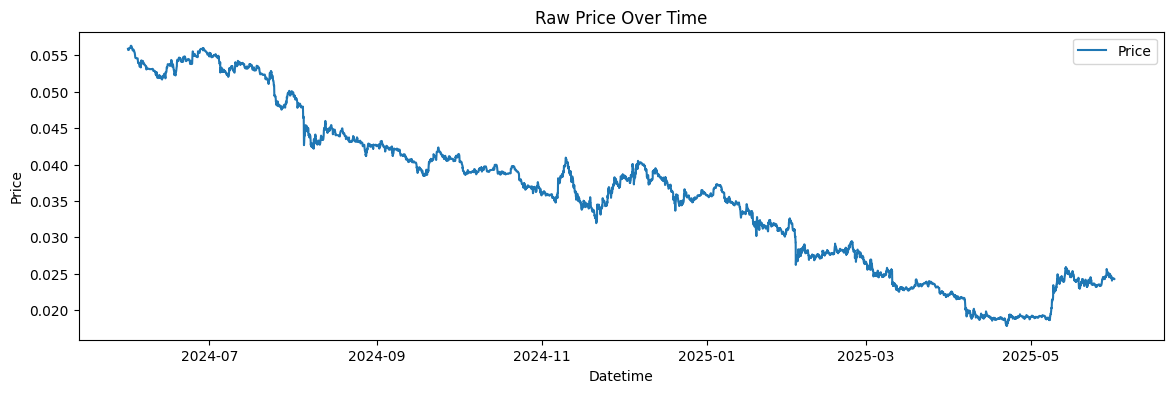

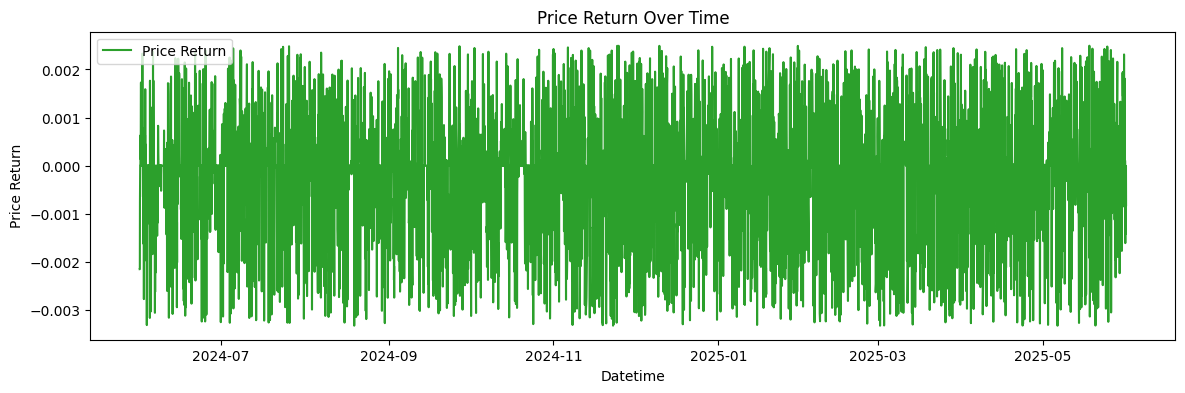

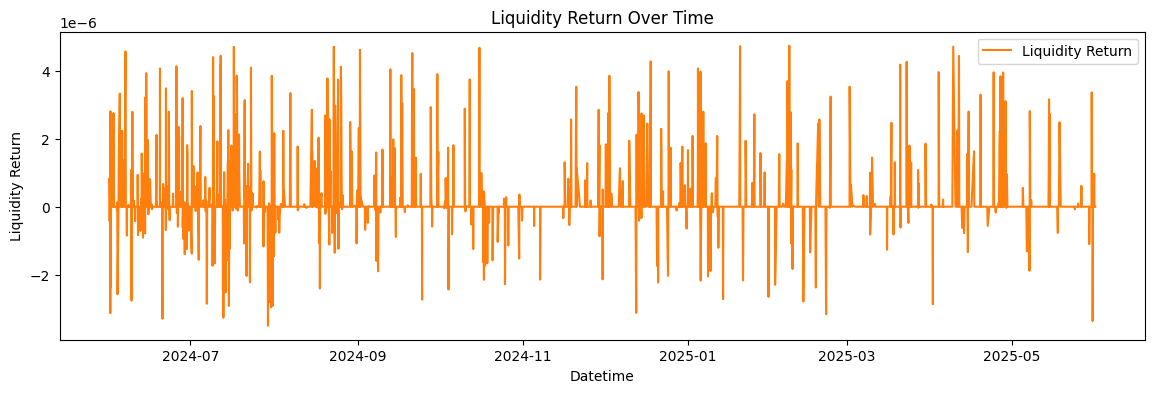

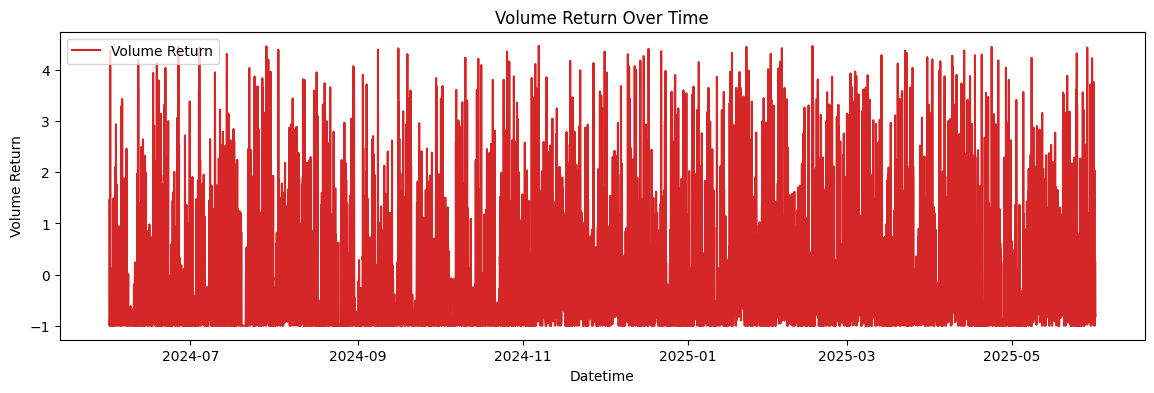

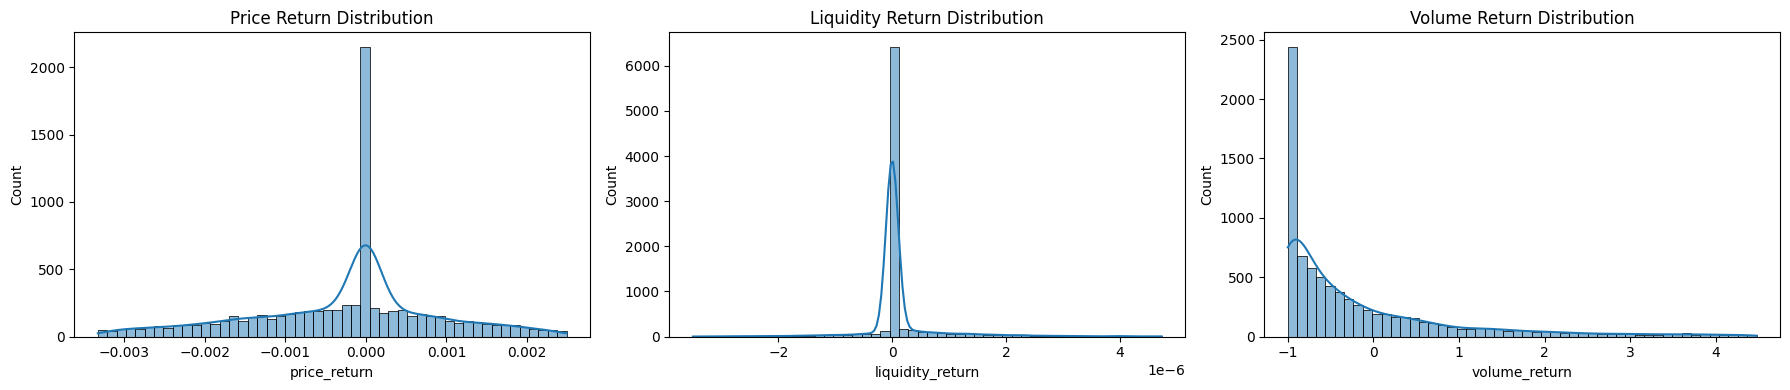

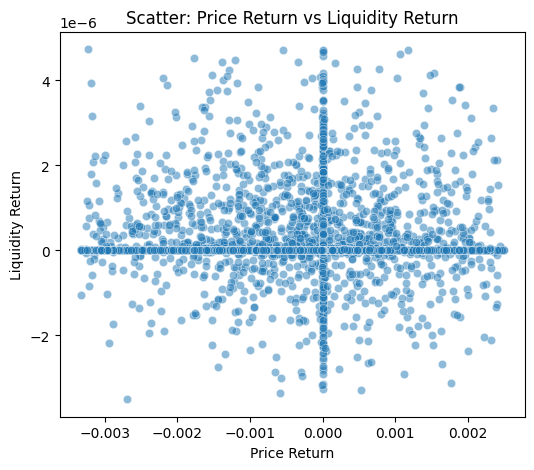

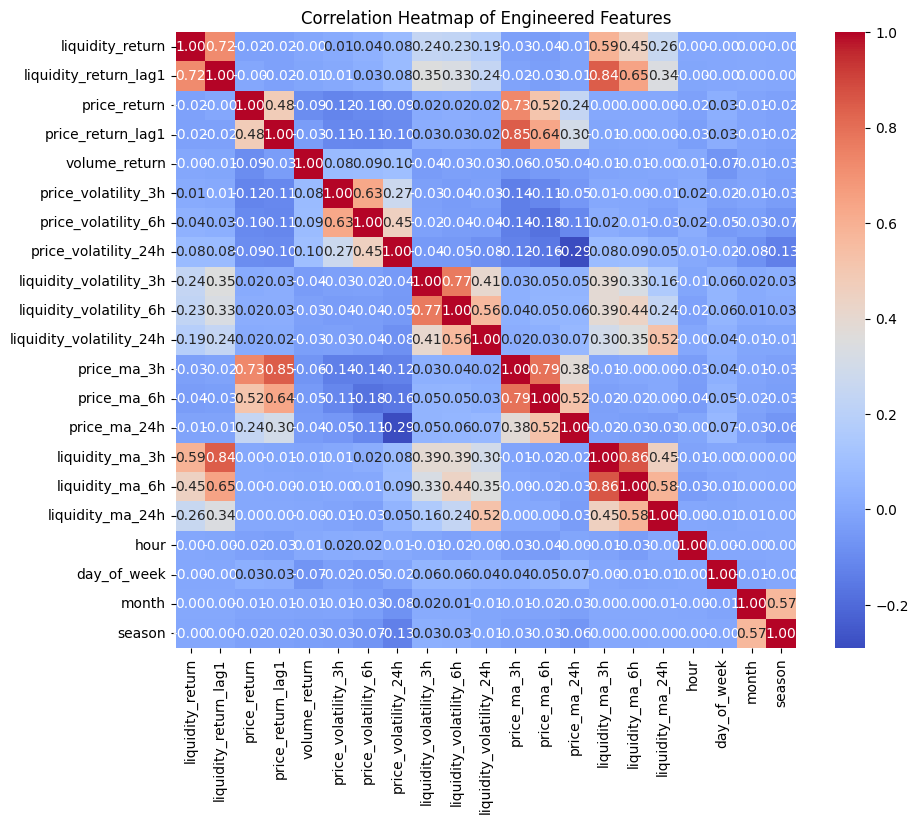

In [ ]:
# Plot raw price over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['price'], label='Price', color='tab:blue')
plt.title('Raw Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot price return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['price_return'], label='Price Return', color='tab:green')
plt.title('Price Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price Return')
plt.legend()
plt.show()

# Plot liquidity return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['liquidity_return'], label='Liquidity Return', color='tab:orange')
plt.title('Liquidity Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()

# Plot volume return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['volume_return'], label='Volume Return', color='tab:red')
plt.title('Volume Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Volume Return')
plt.legend()
plt.show()

# Histograms of returns
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df_fe['price_return'].dropna(), bins=50, ax=axs[0], kde=True)
axs[0].set_title('Price Return Distribution')
sns.histplot(df_fe['liquidity_return'].dropna(), bins=50, ax=axs[1], kde=True)
axs[1].set_title('Liquidity Return Distribution')
sns.histplot(df_fe['volume_return'].dropna(), bins=50, ax=axs[2], kde=True)
axs[2].set_title('Volume Return Distribution')
plt.tight_layout()
plt.show()

# Scatter plot: price_return vs liquidity_return
plt.figure(figsize=(6, 5))
sns.scatterplot(x=df_fe['price_return'], y=df_fe['liquidity_return'], alpha=0.5)
plt.title('Scatter: Price Return vs Liquidity Return')
plt.xlabel('Price Return')
plt.ylabel('Liquidity Return')
plt.show()

# Correlation heatmap of engineered features
features = [
    'liquidity_return', 'liquidity_return_lag1', 
    'price_return', 'price_return_lag1', 
    'volume_return',
    'price_volatility_3h', 'price_volatility_6h', 'price_volatility_24h',
    'liquidity_volatility_3h', 'liquidity_volatility_6h', 'liquidity_volatility_24h',
    'price_ma_3h', 'price_ma_6h', 'price_ma_24h',
    'liquidity_ma_3h', 'liquidity_ma_6h', 'liquidity_ma_24h',
    'hour', 'day_of_week', 'month', 'season'
]
plt.figure(figsize=(10, 8))
sns.heatmap(df_fe[features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

## Benchmark Model and Evaluation Functions

We start with a naive benchmark model that predicts the next value as the current value (a persistence or "random walk" model). We also define evaluation functions (e.g., MAE, RMSE, MAPE) to assess model performance. These functions can be reused for more sophisticated models later.

In [ ]:
# Prepare training data: split chronologically by train_end_date (date-based)
def get_chronological_split(df, train_end_date):
    """
    Split a DataFrame into train and test sets based on a train_end_date (string or datetime).
    All rows with datetime <= train_end_date go to train, the rest to test.
    """
    df = df.sort_values('datetime').reset_index(drop=True)
    if isinstance(train_end_date, str):
        train_end_date = pd.to_datetime(train_end_date)
    train_df = df[df['datetime'] <= train_end_date].reset_index(drop=True)
    test_df = df[df['datetime'] > train_end_date].reset_index(drop=True)
    return train_df, test_df

In [ ]:
def naive_predict(series):
    """Naive model: predicts next value as the current value (persistence)."""
    # Shift series by 1 to get prediction for t+1 at time t
    return series.shift(1)

def evaluate_predictions(y_true, y_pred):
    """Compute MAE, RMSE, and MAPE for predictions."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Liquidity Return"):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index, y_true, label="Actual", color="tab:blue")
    plt.plot(y_true.index, y_pred, label="Predicted", color="tab:orange")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Liquidity Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Example: Benchmark for price prediction
test_split = 0.9
_, test_df = get_chronological_split(df_fe, train_end_date)
y_true = test_df['liquidity_return'].iloc[1:]  # true values from t=1
naive_pred = naive_predict(test_df['liquidity_return']).iloc[1:]  # predictions for t=1 onward
results = evaluate_predictions(y_true, naive_pred)
print("Naive benchmark results for liquidity_return:", results)

Naive benchmark results for liquidity_return: {'MAE': 1.0966946156382623e-07, 'RMSE': np.float64(3.8225141953155006e-07), 'MAPE': nan}


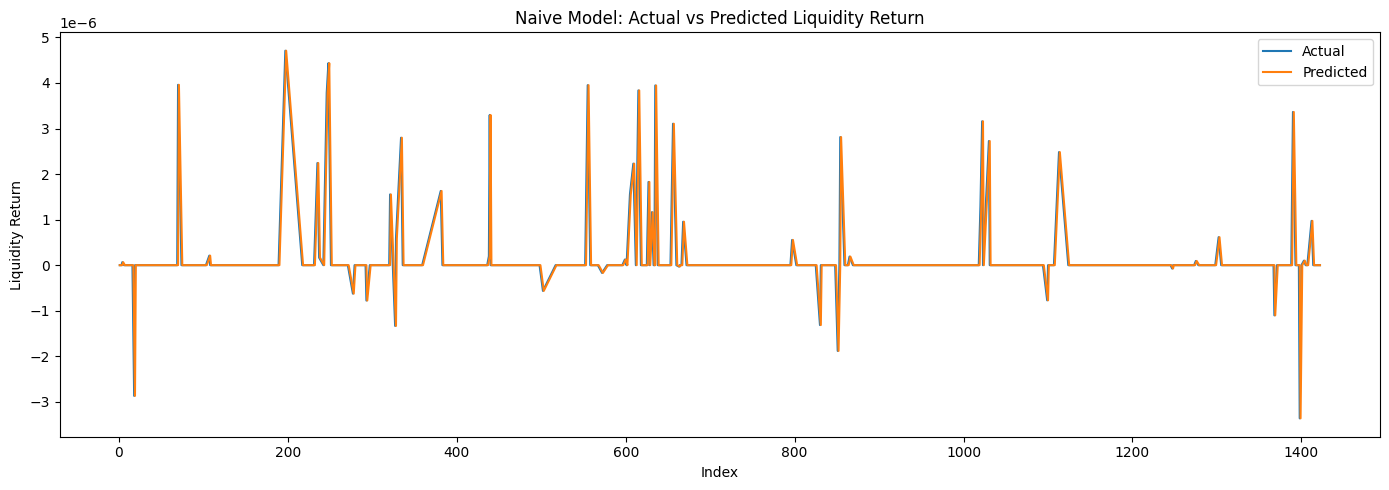

In [ ]:
# Plot for Naive Benchmark Model
plot_actual_vs_predicted(y_true, naive_pred, title="Naive Model: Actual vs Predicted Liquidity Return")

## Zero-inflated LSTM Regression: Multi-Pool Pretraining and Fine-Tuning

We now use a zero-inflated LSTM model to predict liquidity returns from price and engineered features. The model is first pretrained on multiple pools, then fine-tuned on a specific pool. Both the classifier (zero/nonzero) and regressor (nonzero) use LSTM layers.

In [ ]:
# --- ZeroInflatedLSTM class for zero-inflated modeling (PyTorch version, with internal scaling) ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler

class ZeroInflatedLSTM(nn.Module):
    def __init__(self, input_size, lstm_units=32, dense_units=16):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_units, batch_first=True)
        self.shared_dense = nn.Linear(lstm_units, dense_units)
        # Classifier head
        self.classifier = nn.Linear(dense_units, 1)
        # Regressor head
        self.regressor_dense = nn.Linear(dense_units, dense_units)
        self.regressor = nn.Linear(dense_units, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.feature_scaler = None
        self.target_reg_scaler = None
        self._input_size = input_size

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.relu(self.shared_dense(x))
        cls_out = self.sigmoid(self.classifier(x))
        reg_x = self.relu(self.regressor_dense(x))
        reg_out = self.regressor(reg_x)
        return cls_out, reg_out

    def fit(self, X, y_cls, y_reg, epochs=20, batch_size=64, lr=0.001, val_data=None, verbose=1):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        # Fit scalers on training data
        n_samples, n_lags, n_features = X.shape
        self.feature_scaler = StandardScaler()
        X_reshaped = X.reshape(-1, n_features)
        self.feature_scaler.fit(X_reshaped)
        X_scaled = self.feature_scaler.transform(X_reshaped).reshape(n_samples, n_lags, n_features)
        self.target_reg_scaler = StandardScaler()
        self.target_reg_scaler.fit(y_reg.reshape(-1, 1))
        y_reg_scaled = self.target_reg_scaler.transform(y_reg.reshape(-1, 1)).flatten()
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
        y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32, device=device).unsqueeze(1)
        y_reg_tensor = torch.tensor(y_reg_scaled, dtype=torch.float32, device=device).unsqueeze(1)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        n = X_tensor.shape[0]
        for epoch in range(epochs):
            self.train()
            perm = torch.randperm(n)
            total_loss = 0
            for i in range(0, n, batch_size):
                idx = perm[i:i+batch_size]
                xb, ycb, yrb = X_tensor[idx], y_cls_tensor[idx], y_reg_tensor[idx]
                optimizer.zero_grad()
                cls_pred, reg_pred = self(xb)
                loss = custom_zi_loss(cls_pred, reg_pred, ycb, yrb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * len(idx)
            if verbose and (epoch % 5 == 0 or epoch == epochs-1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/n:.4f}")
                if val_data is not None:
                    val_loss = self.evaluate(*val_data)
                    print(f"  Validation Loss: {val_loss:.4f}")
        return self

    def evaluate(self, X, y_cls, y_reg):
        device = next(self.parameters()).device
        self.eval()
        with torch.no_grad():
            n_samples, n_lags, n_features = X.shape
            X_scaled = self.feature_scaler.transform(X.reshape(-1, n_features)).reshape(n_samples, n_lags, n_features)
            y_reg_scaled = self.target_reg_scaler.transform(y_reg.reshape(-1, 1)).flatten()
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
            y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32, device=device).unsqueeze(1)
            y_reg_tensor = torch.tensor(y_reg_scaled, dtype=torch.float32, device=device).unsqueeze(1)
            cls_pred, reg_pred = self(X_tensor)
            loss = custom_zi_loss(cls_pred, reg_pred, y_cls_tensor, y_reg_tensor)
        return loss.item()

    def predict(self, X):
        device = next(self.parameters()).device
        self.eval()
        with torch.no_grad():
            n_samples, n_lags, n_features = X.shape
            X_scaled = self.feature_scaler.transform(X.reshape(-1, n_features)).reshape(n_samples, n_lags, n_features)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
            cls_pred, reg_pred = self(X_tensor)
            cls_pred = (cls_pred.cpu().numpy().flatten() > 0.5).astype(int)
            reg_pred = reg_pred.cpu().numpy().flatten()
            # Inverse transform regression output
            reg_pred = self.target_reg_scaler.inverse_transform(reg_pred.reshape(-1, 1)).flatten()
        return reg_pred, cls_pred
    
    def recursive_forecast(self, df, features, n_lags, forecast_horizon=20, verbose=False):
        """
        Recursive multi-step forecast, updating lagged and rolling features.
        df: DataFrame with all features (including price/time/rolling features)
        features: list of feature columns to use for prediction
        forecast_horizon: number of steps to forecast
        Returns: list of predicted liquidity_return values
        """
        df = df.copy()
        reg_preds = []
        cls_preds = []
        history = df.iloc[:-forecast_horizon].copy()

        for step in range(forecast_horizon):
            next_idx = history.index[-1] + 1

            # Compose next row's features
            next_row = self._update_rolling_features(df, next_idx, features, history)
            if verbose:
                print(f"Step {step + 1}/{forecast_horizon}, Predicting for index {next_idx} with features: {next_row}")

            # Prepare input sequence for LSTM
            X_seq = history[features].iloc[-n_lags:].values
            X_seq = X_seq.reshape(1, n_lags, len(features))
            reg_pred, cls_pred = self.predict(X_seq)
            reg_pred = reg_pred[0]
            cls_pred = cls_pred[0]
            pred_val = reg_pred if cls_pred == 0 else 0.0
            reg_preds.append(reg_pred)
            cls_preds.append(cls_pred)
            # Update history with new prediction
            new_row = df.iloc[len(history)] if len(history) < len(df) else history.iloc[-1].copy()
            new_row = new_row.copy()
            new_row['liquidity_return'] = pred_val
            history = pd.concat([history, pd.DataFrame([new_row], index=[next_idx])])

        return np.array(reg_preds), np.array(cls_preds)


    @staticmethod
    def _update_rolling_features(df, next_idx, features, history):
        """
        Helper to compute next row's lagged and rolling features for recursive forecasting.
        """
        import numpy as np

        next_row = {}

        for col in features:
            if 'liquidity' not in col:
                # Non-liquidity features: take from df if available
                next_row[col] = df.loc[next_idx, col] if next_idx in df.index else np.nan
                continue

            # Liquidity-based features
            if col.endswith('return'):
                next_row[col] = history[col].iloc[-1] if not history[col].empty else np.nan
            elif 'volatility' in col:
                try:
                    win = int(col.split('_')[-1][:-1])
                    next_row[col] = history['liquidity_return'].iloc[-win:].std()
                except Exception:
                    next_row[col] = np.nan
            elif 'ma' in col:
                try:
                    win = int(col.split('_')[-1][:-1])
                    next_row[col] = history['liquidity_return'].iloc[-win:].mean()
                except Exception:
                    next_row[col] = np.nan
            elif 'lag' in col:
                try:
                    lag_num = int(col.split('lag')[-1])
                    next_row[col] = history[col].iloc[-lag_num] if len(history) >= lag_num else np.nan
                except Exception:
                    next_row[col] = np.nan
            else:
                next_row[col] = np.nan  # fallback for unexpected patterns

        return next_row

def custom_zi_loss(cls_pred, reg_pred, y_cls, y_reg):
    bce = nn.BCELoss()(cls_pred, y_cls)
    mask = (y_cls == 0).float()
    if mask.sum() > 0:
        mse = ((reg_pred.squeeze() - y_reg.squeeze()) ** 2 * mask).sum() / (mask.sum() + 1e-6)
    else:
        mse = torch.tensor(0.0, device=reg_pred.device)
    return bce + mse

In [ ]:
# --- Prepare data for LSTM: multi-pool pretraining and fine-tuning ---

n_lags = 5

def get_X_y(df, features, target_col, n_lags=n_lags):
    X, y_cls, y_reg = [], [], []
    for i in range(n_lags, len(df)):
        X.append(df[features].iloc[i-n_lags:i].values)
        target = df[target_col].iloc[i]
        y_cls.append(1 if target == 0 else 0)
        y_reg.append(target)
    return np.array(X), np.array(y_cls), np.array(y_reg)

# Dynamically generate lagged feature names
def make_lagged_features(base, n_lags):
    return [f"{base}_lag{lag}" for lag in range(1, n_lags+1)]

lstm_features = [
    'price_return', 'price_volatility_3h', 'price_volatility_6h', 'price_volatility_24h',
    'liquidity_volatility_3h', 'liquidity_volatility_6h', 'liquidity_volatility_24h',
    'price_ma_3h', 'price_ma_6h', 'price_ma_24h',
    'liquidity_ma_3h', 'liquidity_ma_6h', 'liquidity_ma_24h',
    'hour', 'day_of_week', 'month', 'season',
] + make_lagged_features('price_return', n_lags) + make_lagged_features('liquidity_return', n_lags)

target = 'liquidity_return'

def dropna_lstm(df, features, target_col):
    mask = df[features + [target_col]].notnull().all(axis=1)
    return df.loc[mask].reset_index(drop=True)

X_pre_list, y_cls_pre_list, y_reg_pre_list = [], [], []
for pool_addr in pool_addresses:
    df_pool = pool_data_dict[pool_addr].copy()
    df_pool = feature_engineering(df_pool)
    df_pool = df_pool[df_pool['datetime'] <= pd.to_datetime(train_end_date)].copy()
    df_pool = add_lagged_features(df_pool, n_lags=n_lags)
    df_pool['pool'] = pool_addr
    df_pool = dropna_lstm(df_pool, lstm_features, target)
    Xp, yc, yr = get_X_y(df_pool, lstm_features, target, n_lags=n_lags)
    X_pre_list.append(Xp)
    y_cls_pre_list.append(yc)
    y_reg_pre_list.append(yr)

X_pre = np.concatenate(X_pre_list, axis=0)
y_cls_pre = np.concatenate(y_cls_pre_list, axis=0)
y_reg_pre = np.concatenate(y_reg_pre_list, axis=0)

df_main = pool_data_dict[main_pool_address].copy()
df_main = feature_engineering(df_main)
df_main = add_lagged_features(df_main, n_lags=n_lags)
df_main['pool'] = main_pool_address
df_main = dropna_lstm(df_main, lstm_features, target)
df_finetune, df_test = get_chronological_split(df_main, train_end_date)
X_fine, y_cls_fine, y_reg_fine = get_X_y(df_finetune, lstm_features, target, n_lags=n_lags)

print(f"Pretraining set shape: {X_pre.shape}, {y_cls_pre.shape}, {y_reg_pre.shape}")
print(f"Fine-tuning set shape: {X_fine.shape}, {y_cls_fine.shape}, {y_reg_fine.shape}")

Pretraining set shape: (64242, 5, 27), (64242,), (64242,)
Fine-tuning set shape: (6673, 5, 27), (6673,), (6673,)


In [ ]:
# --- Train and fine-tune ZeroInflatedLSTM ---
input_size = X_pre.shape[2]  # number of features per timestep
lstm_model = ZeroInflatedLSTM(input_size, lstm_units=32, dense_units=16)
lstm_model.train()

# Pretrain on all pools
print("Pretraining on multiple pools...")
lstm_model.fit(X_pre, y_cls_pre, y_reg_pre, epochs=20, batch_size=64, lr=0.001, verbose=1)
# The idea is to train this model on multiple pools to learn general patterns in liquidity and price movements.
# Then, the model is saved and can be loaded for fine-tuning on a specific pool.

# Fine-tune on specific pool
print(f"Fine-tuning on pool: {main_pool_address}...")
lstm_model.fit(X_fine, y_cls_fine, y_reg_fine, epochs=20, batch_size=32, lr=0.001, verbose=1)

Pretraining on multiple pools...
Epoch 1/20, Loss: 61.9925
Epoch 1/20, Loss: 61.9925
Epoch 6/20, Loss: 52.9859
Epoch 6/20, Loss: 52.9859
Epoch 11/20, Loss: 41.5020
Epoch 11/20, Loss: 41.5020
Epoch 16/20, Loss: 33.2027
Epoch 16/20, Loss: 33.2027
Epoch 20/20, Loss: 28.2836
Fine-tuning on pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed...
Epoch 20/20, Loss: 28.2836
Fine-tuning on pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed...
Epoch 1/20, Loss: 32.9201
Epoch 1/20, Loss: 32.9201
Epoch 6/20, Loss: 20.0803
Epoch 6/20, Loss: 20.0803
Epoch 11/20, Loss: 15.8420
Epoch 11/20, Loss: 15.8420
Epoch 16/20, Loss: 12.8976
Epoch 16/20, Loss: 12.8976
Epoch 20/20, Loss: 11.1541
Epoch 20/20, Loss: 11.1541


ZeroInflatedLSTM(
  (lstm): LSTM(27, 32, batch_first=True)
  (shared_dense): Linear(in_features=32, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
  (regressor_dense): Linear(in_features=16, out_features=16, bias=True)
  (regressor): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Test set shape: (1418, 5, 27), (1418,), (1418,)
Classifier accuracy: 0.8004231311706629
Conditional regression RMSE (nonzero): 1.7976154873733993e-12
Confusion matrix (rows: true, cols: pred):
 [[ 101  172]
 [ 111 1034]]


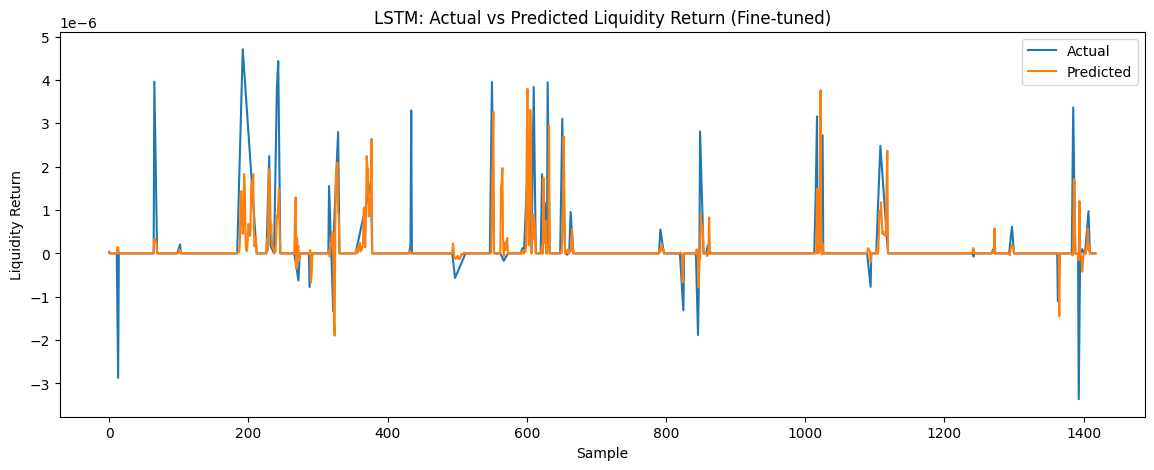

In [ ]:
# Evaluate on test set
X_test, y_cls_test, y_reg_test = get_X_y(df_test, lstm_features, target, n_lags=n_lags)
print(f"Test set shape: {X_test.shape}, {y_cls_test.shape}, {y_reg_test.shape}")
y_reg_pred, y_cls_pred = lstm_model.predict(X_test)
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
mask = y_cls_test == 0
reg_rmse = mean_squared_error(y_reg_test[mask], y_reg_pred[mask])
cls_acc = accuracy_score(y_cls_test, y_cls_pred)
print(f"Classifier accuracy: {cls_acc}")
print(f"Conditional regression RMSE (nonzero): {reg_rmse}")
cm = confusion_matrix(y_cls_test, y_cls_pred)
print("Confusion matrix (rows: true, cols: pred):\n", cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
y_reg_test_masked = np.zeros(len(y_reg_test))
y_reg_test_masked[mask] = y_reg_test[mask]
y_reg_pred_masked = np.zeros(len(y_reg_pred))
y_reg_pred_masked[mask] = y_reg_pred[mask]
plt.plot(y_reg_test_masked, label='Actual')
plt.plot(y_reg_pred_masked, label='Predicted')
plt.title('LSTM: Actual vs Predicted Liquidity Return (Fine-tuned)')
plt.xlabel('Sample')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()

In [ ]:
# Example usage of autoregressive forecasting
forecast_horizon = 20
y_reg_pred, y_cls_pred = lstm_model.recursive_forecast(df_test, lstm_features, n_lags=n_lags, forecast_horizon=forecast_horizon, verbose=True)
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
mask = y_cls_test == 0
reg_rmse = mean_squared_error(y_reg_test[mask], y_reg_pred[mask])
cls_acc = accuracy_score(y_cls_test, y_cls_pred)
print(f"Classifier accuracy: {cls_acc}")
print(f"Conditional regression RMSE (nonzero): {reg_rmse}")
cm = confusion_matrix(y_cls_test, y_cls_pred)
print("Confusion matrix (rows: true, cols: pred):\n", cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
y_reg_test_masked = np.zeros(len(y_reg_test))
y_reg_test_masked[mask] = y_reg_test[mask]
y_reg_pred_masked = np.zeros(len(y_reg_pred))
y_reg_pred_masked[mask] = y_reg_pred[mask]
plt.plot(y_reg_test_masked, label='Actual')
plt.plot(y_reg_pred_masked, label='Predicted')
plt.title('LSTM: Actual vs Predicted Liquidity Return (Fine-tuned)')
plt.xlabel('Sample')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()



Step 1/20, Predicting for index 1403 with features: {'price_return': np.float64(0.0010076093911421946), 'price_volatility_3h': np.float64(0.0003548389756109926), 'price_volatility_6h': np.float64(0.0006019252208598857), 'price_volatility_24h': np.float64(0.001045367246834037), 'liquidity_volatility_3h': np.float64(3.303937849234254e-08), 'liquidity_volatility_6h': np.float64(1.4188086204578779e-06), 'liquidity_volatility_24h': np.float64(1.2170484326810165e-06), 'price_ma_3h': np.float64(0.0006527704155312822), 'price_ma_6h': np.float64(0.0001661473447132261), 'price_ma_24h': np.float64(0.0004395748156520094), 'liquidity_ma_3h': np.float64(3.303937849234254e-08), 'liquidity_ma_6h': np.float64(-8.241693919367835e-07), 'liquidity_ma_24h': np.float64(1.443271843842853e-07), 'hour': np.int32(3), 'day_of_week': np.int32(5), 'month': np.int32(5), 'season': np.int64(1), 'price_return_lag1': np.float64(0.0006527704155312822), 'price_return_lag2': np.float64(0.0002979314399203699), 'price_retur

# Hyperparameter Tuning: LSTM Grid Search

We perform hyperparameter tuning for the LSTM model using grid search. This automated process tests different combinations of hyperparameters (e.g., LSTM units, dense units, learning rate, batch size) to find the best model configuration.

In [ ]:
# --- Grid search for LSTM hyperparameters ---
from sklearn.model_selection import ParameterGrid

def grid_search_lstm(
    df,
    features,
    target_col,
    param_grid,
    validation_split=0.2,
    n_lags=5,
    epochs=10,
    verbose=1
):
    """
    Automated grid search for ZeroInflatedLSTM.
    - df: DataFrame with all features and target
    - features: list of feature names
    - target_col: name of target column
    - param_grid: dict of hyperparameters (lstm_units, dense_units, batch_size, etc.)
    - validation_split: fraction of data for validation
    - n_lags: number of lags (timesteps)
    - epochs: training epochs
    Returns best model, best params, and results list.
    """
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []
    df_clean = df.copy()
    mask = df_clean[features + [target_col]].notnull().all(axis=1)
    df_clean = df_clean.loc[mask].reset_index(drop=True)
    X, y_cls, y_reg = [], [], []
    for i in range(n_lags, len(df_clean)):
        X.append(df_clean[features].iloc[i-n_lags:i].values)
        target = df_clean[target_col].iloc[i]
        y_cls.append(1 if target == 0 else 0)
        y_reg.append(target)
    X = np.array(X)
    y_cls = np.array(y_cls)
    y_reg = np.array(y_reg)
    split_idx = int(len(X) * (1 - validation_split))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_cls_train, y_cls_val = y_cls[:split_idx], y_cls[split_idx:]
    y_reg_train, y_reg_val = y_reg[:split_idx], y_reg[split_idx:]
    for params in ParameterGrid(param_grid):
        model = ZeroInflatedLSTM(
            input_shape=(n_lags, len(features)),
            lstm_units=params.get('lstm_units', 32),
            dense_units=params.get('dense_units', 16),
            learning_rate=params.get('learning_rate', 0.001)
        )
        model.fit(
            X_train, y_cls_train, y_reg_train,
            epochs=epochs,
            batch_size=params.get('batch_size', 64),
            validation_split=0.1,
            verbose=0
        )
        reg_pred, cls_pred = model.predict(X_val)
        mask_val = y_cls_val == 0
        rmse = mean_squared_error(y_reg_val[mask_val], reg_pred[mask_val])
        results.append((params, rmse))
        if verbose:
            print(f"Params: {params}, Val RMSE: {rmse}")
        if rmse < best_score:
            best_score = rmse
            best_params = params
            best_model = model
    if verbose:
        print(f"\nBest params: {best_params}, Best Val RMSE: {best_score}")
    return best_model, best_params, results

In [ ]:
# --- Example grid search usage ---
param_grid = {
    'lstm_units': [16, 32],
    'dense_units': [8, 16],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64]
}

# Perform grid search
best_model, best_params, search_results = grid_search_lstm(
    df_all,
    features=lstm_features,
    target_col='liquidity_return',
    param_grid=param_grid,
    validation_split=0.2,
    n_lags=5,
    epochs=10,
    verbose=1
)

print("Best hyperparameters:", best_params)
# Plot search results
results_df = pd.DataFrame(search_results, columns=['params', 'rmse'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='params', y='rmse', data=results_df)
plt.title("Grid Search Results: RMSE by Hyperparameter Combination")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TypeError: ZeroInflatedLSTM.__init__() got an unexpected keyword argument 'input_shape'